Retail Spatial Interaction Model
===

This is an application submitted for assessment as part of the Programming for Geographical Information Analysis: Core Skills module, in the MSc of Geographical Information Science program at the School of Geography, University of Leeds.
The application is a Spatial Interaction Model that estimates the flow of grocery spenditure from Output Areas (OA) to grocery stores in Leeds. 

The application employs a production constrained, entropy-maximizing Spatial Interaction Model that estimates expenditure flow from Output Areas to available stores based on:
+ Store Accessibility: Derived from the euclidian distances from each zone's centroid to the store, while accounting for variations in the travel distance tolerance for the inhabitants of each zone based on its Output Area Classification class
+ Attraction: Derived from store's floorspace, augmented by each the brand's relative attractiveness

Furthermore, the model assumes that all spenditure flow is contained within the study area and that all the demand for groceries is met by the stores (Birkin et al., 2017). For a full review of the SIM, refere to the references at the bottom of the notebook. 

## Importing Required Modules

First we import the modules upon which this application relies

In [1]:
import csv
import matplotlib
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry

## Creating the Object Classes and their Methods

To make the application extensible and thus applicable in different scenarios, an attempt is made to idientify the objects of concern and to abstract their relavent properties.

### Stores Object Class
We start with a Stores Object Class which defines the Stores objects. Properties of interest are:
+ Name: which will be used to identify individual stores
+ Brand: which will determine a stores relative attractiveness
+ easting and northing: stores location, which 
+ footage: which is also relavent to a stores attraction

Stores have two major methods:
+ dist_to_zone(demand_zone) which computes the distance from the subject store to a given DemandZone object type.
+ get_store_revenue(flows) which gets the store's revenue from the Flows Matrix produced by the DemandZones method comp_flow()

In [2]:
class Stores:
	def __init__(self, name, brand, easting, northing, footage):
		"""
		name - name of the store (string)
		brand - store brand (string)
		easting - easting of the store's centroid (float)
		northing - northing value of the store centroid (float)
		footage - area of the store in square feet (integer)
		"""
		self.name = name
		self.brand = brand
		self.footage = int(footage)
		self.easting = float(easting)
		self.northing = float(northing)
		self.location = [float(self.easting), float(self.northing)]


	def __str__(self):
		return "this is the " + str(self.name) + " store of "+\
str(self.brand) + "\nFloorspace: " + str(self.footage) + " sq.feet"


	def dist_to_zone(self, demand_zone):
		"""
		Compute distances from store to the centroids of demand zones

		arguments:
		demand_zones -> DemandZones object

		returns:
		distance to demand_zone centroid -> float
		"""
		self.demand_zone = demand_zone
		return abs(((self.easting - self.demand_zone.c_easting)\
**2 + (self.northing - self.demand_zone.c_northing)**2)**0.5)/1000



	def get_store_revenue(self, flows):
		"""
		Get store's total revenue from Flows Matrix

		arguments:
		flow -> Flows Matrix, computed from the DemandZones.comp_flows()
				method -> pandas DataFrame

		returns:
		store revenue -> float

		"""
		self.flow = flows
		return self.flow.loc['Store_Revenue'][self.name]

### DemandZones Object Class
The DemandZones represent the Output Areas in as much as they are of interest to the SIM application. Each demand zone has:
+ OA11CD: an Output Area code, which is an ID field used to link demand zone attributes to demand zone polygon.
+ expenditure: the amount of money available in the zone for grocery expenses.
+ oac: the Output Area Classification number of the zone, used to estimate the distance detterance parameter of its inhabitants
+ c_easting and c_northing: the coordinates of the OA's centroid


#### DemandZones.comp_flow(stores, alphas, betas)
This is the major method in this application. It takes in four arguments:
+ self: the DemandZones object for which the Flows Matrix is to be computed
+ alphas: a dictionary relating each brand name to it relative attractiveness
+ betas: a dictionary relating each OAC class to its distance deterance parameter
+ stores: a list of Stores objects to which the spenditure will flow

The self argument accepts two datatypes:
+ DemandZones object: in which case the method returns the flows from this one demand zone to each store in the input stores
+ List of DemandZone objects: in which case the method returns a Flows Matrix from each demand zone to each stores and computes each stores weekly revenue

The method's output is returned in a pandas DataFrame where each column represents a store and each row represents a demand zone. The final row contains the total revenue for each store from all the demand zones.


In [3]:
class DemandZones:
	def __init__(self, OA11CD, expenditure, oac, c_easting, c_northing):
		"""
		OA11CD - Demand Zone code (string)
		expenditure - amount of exoenditure available in DemandZone per week
		oac -> open area classification code of DemandZone
		suppy -> the stores with which the DemandZone interacts (list of Stores)
		"""
		self.OA11CD = OA11CD
		self.expenditure = float(expenditure)
		self.oac = oac
		self.c_easting = float(c_easting)
		self.c_northing = float(c_northing)

	def __str__(self):
		return "OA11CD: " + str(self.OA11CD) + "\nSpend: " + \
str(self.expenditure) + " Pounds Sterling per week"


	def getoac(self):
		return self.oac


	def dist_to_store(self, store):
		"""
		Compute the distance to store in kilometers

		arguments:
		store -> Stores object

		returns:
		distance in kilometers -> float
		"""
		return abs(((self.c_easting - store.easting)\
**2 + (self.c_northing - store.northing)**2)**0.5)/1000



	def comp_ai(self, stores, beta, alphas):
		"""
		Compute the Ai term of the SIM equation.

		The Ai term ensures that all available spenditure in a demand zone is
		allocated to a store.

		areguments:
		stores: the list of store objects to which the spenditure will flow
			    these stores represent the supply side of SIM -> list of
				Store Objects.
		beta: the distance deterance parameter of the zone-> float
	    alphas: a dictionary relating each brand to its relative
				attractiveness -> dictionary

		returns:
		Ai term -> float
		"""
		a = 0
		for store in stores:
			dist = self.dist_to_store(store)
			x = beta * dist
			y = float(alphas[store.brand])
			z = (store.footage ** y) * np.exp(-x)
			a += z
		return 1/a





	def comp_flow(self, stores, alphas, betas):
		"""
		Compute the Flows Matrix.

		The Flows Matrix is a matrix that relates the spenditure flows from
		each DemandZones object to every Stores object.

		arguments:
		stores -> list of Stores objects
		alphas -> dictionary relating every brand to its relative
				  attractiveness parameter
	    betas -> dictionary relating each OAC class to its distance deterance
				 parameter

	    returns:
		Flows Matrix -> pandas DataFrame
		"""
		if isinstance(self, DemandZones):
			self.zone_flow = []
			Ai = self.comp_ai(stores, betas[self.oac], alphas)
			O = self.expenditure
			for store in stores:
				W = store.footage ** alphas[store.brand]
				C = self.dist_to_store(store)
				X = betas[self.oac] * C
				f = Ai * O * W * np.exp(-X)
				self.zone_flow.append(f)
			return self.zone_flow
		elif isinstance(self, list):
			flows = []

			brand_names = []
			for store in stores: # to have a brands row in output
				brand_names.append(store.brand)
			for i in range(len(self)):
				zone_flow = []
				Ai = self[i].comp_ai(stores, betas[self[i].oac], alphas)
				O = self[i].expenditure
				for store in stores:
					W = store.footage ** alphas[store.brand]
					C = self[i].dist_to_store(store)
					X = betas[self[i].oac] * C
					f = Ai * O * W * np.exp(-X)
					zone_flow.append(f)
				flows.append(zone_flow)
			columns = []
			for store in stores:
				columns.append(store.name)

			indecies = ['Brand_Name'] # brands row under store name
			for zone in self:
				indecies.append(zone.OA11CD)
			indecies.append('Store_Revenue')
			revenue = [sum(x) for x in zip(*flows)]
			flows.append(revenue)
			flows.insert(0,brand_names)
			return pd.DataFrame(flows, columns=columns, index=indecies)
		else:
			raise Exception('DataType Error: Make sure the self argument\
 is either a DemandZones object or a list of DemandZones objects; the stores\
 argument is a list of Stores objects, the alphas argument is a dictionary\
 whose keys are brands and values are attractiveness parameters and the\
 betas argument is a dictionary whose keys are oac classification codes and\
 values are distance detterance parameters')

### Brands Class
The Brands Class is an object class that represents the brands to which individual stores belong. Each brand has a:
+ Name: Used to distinguish it from other brands
+ Alpha: A measure of relative attractiveness of the brand
+ obs_shares: The brands observed shares; defaults to zero as it is not relavent in this analysis

The Brands class has one method; com_brand_revenue(brand: str, flows: DataFrame)
This method takes in two arguments:
+ brands: the name of the brand for which the total revenue will be computed
+ flows: the flows matrix from which the revenue will be computed

The method returns the total brand revenue, which is the summation of the revenues of all the stores belonging to said brand.

In [4]:
class Brands:
	def __init__(self, name, alpha, obs_shares=0):
		self.name = name
		self.alpha = alpha
		self.obs_shares = obs_shares


	def __str__(self):
		return "Brand Name: " + str(self.name) + "\nRelative Attractiveness:\
 " + str(self.alpha) + "\nObserved Shares: " + str(self.obs_shares)

    
	def comp_brand_revenue(brand, flows):
		"""
		Compute Brand's total revenue.

		arguments:
        brand -> brand name -> string
		flows -> Flows Matrix, the output of comp_flow() -> pandas FataFrame

		returns:
		Total revenue of all the stores belonging to the self brand -> float
		"""
		brand_revenue = 0
		for store in flows.columns[1:]:
			if flows.loc['Brand_Name'][store] == brand:
				brand_revenue += flows.loc['Store_Revenue'][store]
		return brand_revenue

### Output Area Classification (OAC) Class
This is a class that represents Output Areas Classes. Each OAC object has:
+ class_no: the classification number of the class
+ name: the name of the class
+ beta: the class's distance deterance parameter

In [5]:
class OAC:
	def __init__(self, class_no, name, beta):
		self.name = name
		self.class_no = class_no
		self.beta = beta

	def __str__(self):
		return "OAC Class: " + str(self.name) + "\nbeta: " + str(self.beta)

## Input Data

Having defined our classes, we move on to reading our input data. Following that, we construct objects from the input data and store them in appropriate lists and dictionaries.

The input data consists of an OA level shapefile of Leeds and data pertaining to retail supply and demand which was provided during the Applied GIS and Retail Modelling module. The retail data is organized in four comma seperated variables files (csv) with each file representing an object, the headers of the files are reflected in the  \__init__() method of their respective object classes. 

### Brands and Alphas
We read in brands.csv, construct Brands objects and append them to the brands list. We then construct alphas: a dictionary that relates each brand name to its relative attractiveness parameter.




In [6]:
brands = []
alphas = {}
# Read the brands data
with open('brands.csv', 'r') as csv_file:
	csv_reader = csv.reader(csv_file)
	brands_data = []
	for row in csv_reader:
		brands_data.append(row)


# Instantiate Brands and populate brands list
for i in range(len(brands_data)):
	if i > 0: # Ignore header row
		# Instantiate brands
		brands.append(Brands(name=brands_data[i][0],
					  alpha=brands_data[i][1], obs_shares=brands_data[i][2]))
		# Populate alphas dictionary
		alphas[str(brands_data[i][0])] = float(brands_data[i][1])

## DemandZones
We then read in demand.csv, construct DemandZone objects and append them to the demand_zones list.

In [7]:
demand_zones = []
# Read the demand data
with open('demand.csv', 'r') as csv_file:
	csv_reader = csv.reader(csv_file)
	demand_data = []
	for row in csv_reader:
		demand_data.append(row)


#Instantiate DemandZones objects and populate demand_zones list
for i in range(len(demand_data)):
	if i > 0: # Ignore header row
		zone = DemandZones(OA11CD=demand_data[i][0],
							expenditure=demand_data[i][1],
							oac=demand_data[i][2],
							c_easting=demand_data[i][3],
							c_northing=demand_data[i][4])
		demand_zones.append(zone)

## OACs and Betas

Following that, we read in oac.csv, construct OAC objects and append them to the oac lis. From the oac list, we construct a dictionary relating each oac number to its distrance deterance parameter.

In [8]:
oac = []
betas = {}

# Read the OAC data
with open('oac.csv', 'r') as csv_file:
	csv_reader = csv.reader(csv_file)
	oac_data = []
	for row in csv_reader:
		oac_data.append(row)


# Instantiate OAC objects and populate oac list
for i in range(len(oac_data)):
	if i > 0: # Ignore header row
		oa_class = OAC(class_no=oac_data[i][0],
						name=oac_data[i][1], beta=oac_data[i][2])
		# Populate betas
		oac.append(oa_class)
		betas[str(oac_data[i][0])] = float(oac_data[i][2])

## Stores
Finally we read in stores.csv, construct Stores objects and append them to the stores list.

In [9]:
stores = []

# Read the stores data
with open('stores.csv', 'r') as csv_file:
	csv_reader = csv.reader(csv_file)
	stores_data = []
	for row in csv_reader:
		stores_data.append(row)


# Instantiate Stores objects and populate stores list
for i in range(len(stores_data)):
	if i > 0: # Ignore header row
		store = Stores(name=stores_data[i][0],
						brand=stores_data[i][1],
						easting=stores_data[i][2],
						northing=stores_data[i][3],
						footage=stores_data[i][4],)
		stores.append(store)

## Compute the Flows Matrix
The Flows Matrix is a matrix that shows the amount of expenditure that flows from each DemandZones object to each Stores object in the retail model. The DemandZones.comp_flow(demand_zones, stores, alphas, betas) returns the Flows Matrix which is the primary output of this application.

In [10]:

"""
Compute the Flows Matrix.

The Flows Matrix is computed using the retailmodel.DemandZones.comp_flow()
method which returns a tuple. Refer to the retailmodel.py module
"""
df_flow = DemandZones.comp_flow(demand_zones, stores, alphas,
								betas)

## Map the Supply and Demand Data

The code block below maps the DemandZones objects (OA's in this case) symbolized by the amount of spend they have. The stores are symbolized in proportion to floorspace. This map is intended to give the user a general view of the Supply and Demand side situation.

C:\Users\Dell\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


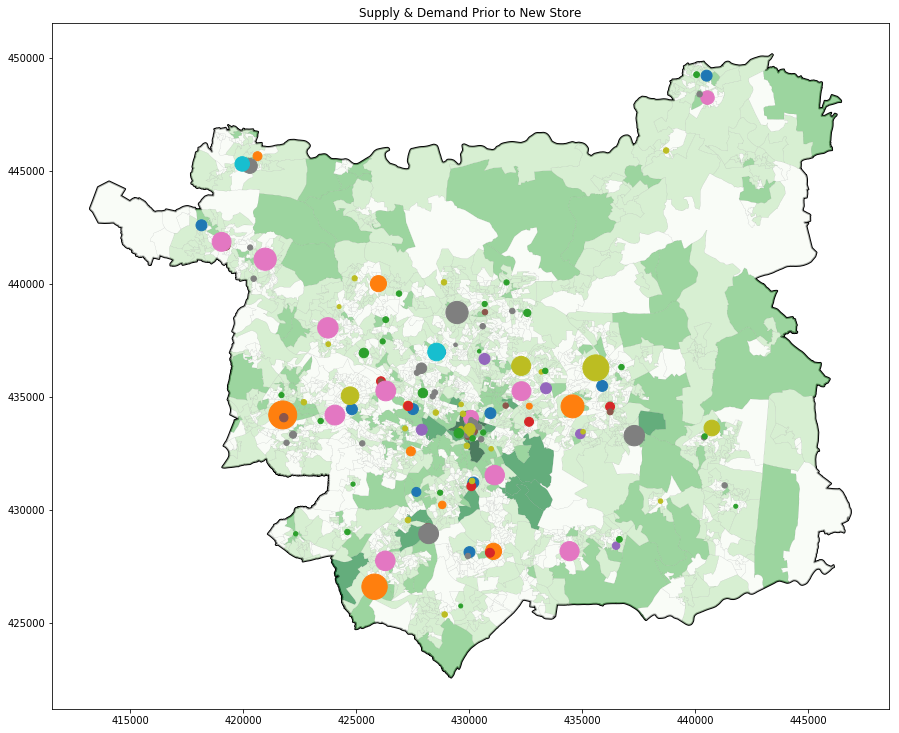

In [11]:
"""
Map the Suppy and Demand Side Data.

First, a pandas DataFrame is created, containing the stores data. Then, the
coordinate values are used to create shapely point objects; and finally the
DataFrame is converted to a GeoDataFrame to be plotted. A markersize column
is computed from the footage column and used to plot stores in proportion to
their floorspace.

The demand side data consists of a shapefile of Leeds at the OA level
containing spend data. Theshapefile is merged with Flows Matrix. OAs are
symbolized according to their spend.

"""

# Get the relavent stores data in a list
stores_list = []
for store in stores:
	name = store.name
	brand = store.brand
	easting = store.easting
	northing = store.northing
	footage = store.footage

	geo_store = [name, brand, easting, northing, footage]

	stores_list.append(geo_store)


# Define attribute field names
store_attr = ['name', 'brand', 'easting', 'northing', 'footage']

# Construct a DataFrame object from the stores_list list
df_stores = pd.DataFrame(stores_list, columns=store_attr)

# Create a 'Coordinates' tuple from the easting and nothing values
df_stores['Coordinates'] = list(zip(df_stores.easting, df_stores.northing))

# Convert the 'Coordinates' tuples to point geometry
df_stores['Coordinates'] = (
	df_stores['Coordinates'].apply(shapely.geometry.Point))

# Construct a GeoDataFrame from df_stores
geo_stores = gpd.GeoDataFrame(df_stores, geometry='Coordinates')
geo_stores['markersize'] = geo_stores.footage/100

# Read study_area shapefile
output_areas = gpd.read_file('geographic_data/study_area.shp')
leeds = gpd.read_file('geographic_data/Leeds.shp')

# Merge the df_flows DataFrame with the shapefile
oa_flow = output_areas.merge(df_flow, left_on='OA11CD', right_index=True)

%matplotlib inline

# Plot the map layers
fig, ax = plt.subplots(1, figsize=(15,15))
leeds.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')
oa_flow.plot(ax=ax, column='Spend', cmap='Greens', scheme='fisher_jenks',
			 linewidth=0.1, edgecolor='gray', alpha=0.7)

# Uncomment the below line and comment out the above line if the plot does not show
#oa_flow.plot(ax=ax, column='Spend', cmap='Greens', linewidth=0.1, edgecolor='gray', alpha=0.7)

geo_stores.plot(ax=ax, column='brand', markersize='markersize')
ax.set_title('Supply & Demand Prior to New Store')
plt.show()


Look!

## Open a New Store

The code block below guides the user through the process of adding a new store to the retail model.

The user is prompted for Stores.__init__() arguments and a Stores object is instantiated accordingly. The Flows Matrix is then re-computed and the user is presented with the new store's estimated revenue, trading intensity and the estimated interbrand canibalization brought about by the new store. The user then has the option to either try again, with alternate store parameters or terminate the process, at which point the output data is written in appropriate file formats.

Do you want to open a new store? 
If yes, insert y, otherwiseinsert any key and press enter: y
Insert the new store's name, without_spaces: rashad
What's your store's brand? Tesco
Insert the easting coordinate value: 429824
insert the northing coordinate value: 436669
Insert the area of your store in suare feet: 12000

Your Brand's current estimated weekly revenue is:
4445392.119777636




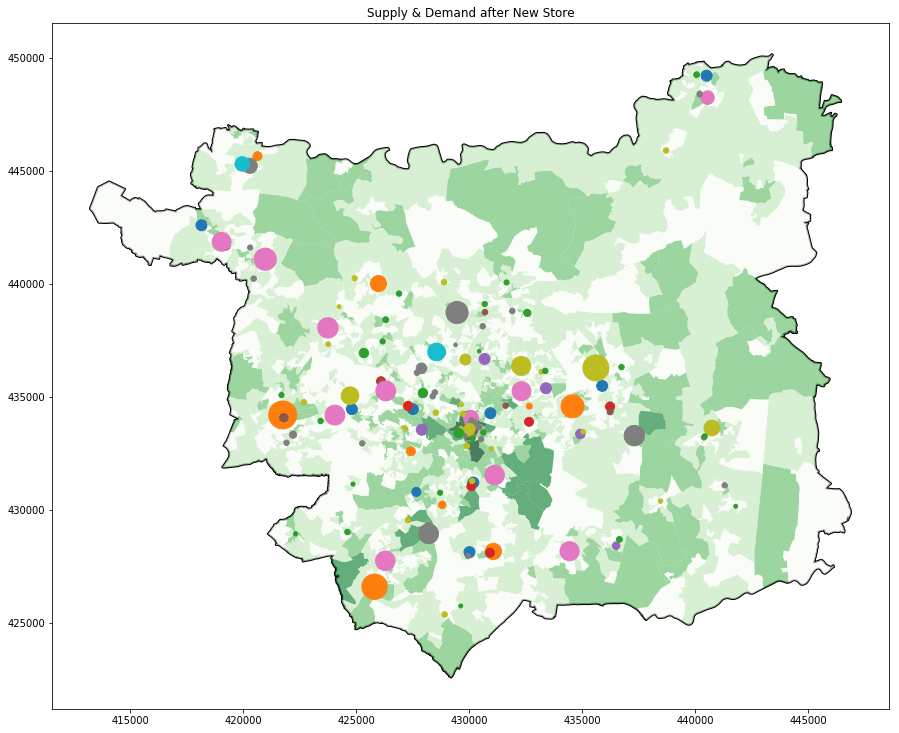

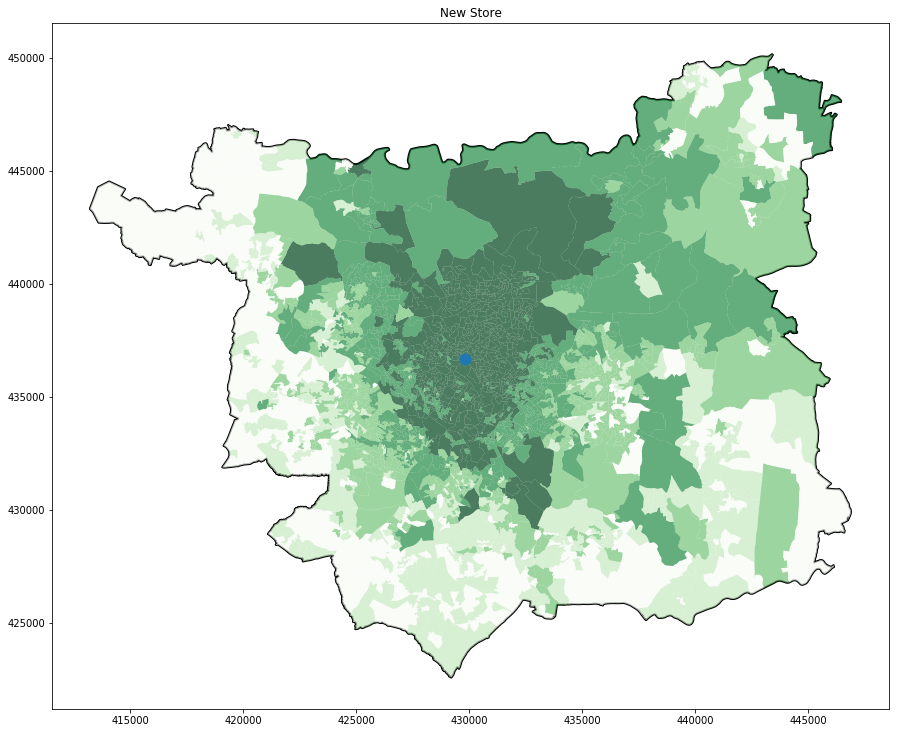

Your new store is estimated to make a weekly revenue of: 
276010.4588097706 Pounds Sterling per week
At a trading intensity of: 
23.000871567480882 per sq.foot 
With a total interbrand canibalization of: 
65651.7739508804 Pounds Sterling per week

Your brands new revenue is estimated to be: 
4655750.804636526

Do you want to try again? 
If yes, insert y, otherwiseinsert any key and press enter: n


In [12]:
"""
Open a new store.

To open a new store, a Stores object must be instantiated. Following that, the
Flows Matrix must be recomputed.

The user is prompted for Stores.__init__() arguments and a Stores object is
instantiated accordingly. The Flows Matrix is then re-computed and the user is
presented with the new store's estimated revenue, trading intensity and the
estimated interbrand canibalization brought about by the new store. The user
then has the option to either try again, with alternate store parameters or
terminate the process, at which point the output data is written in
appropriate file formats
"""

task = input('Do you want to open a new store? \nIf yes, insert y, otherwise\
insert any key and press enter: ')

while task == 'y':
	store_name = input("Insert the new store's name, without_spaces: ")
	#Tesco
	my_brand = input("What's your store's brand? ")
	#429824
	store_e = input("Insert the easting coordinate value: ")
	#436669
	store_n = input("insert the northing coordinate value: ")
	#12000
	store_footage = input("Insert the area of your store in suare feet: ")
	my_store = Stores(name=store_name, brand=my_brand,
					  easting=store_e, northing=store_n,
					  footage=store_footage)
	new_stores = stores.copy()
	new_stores.append(my_store)

	new_df_flow = DemandZones.comp_flow(demand_zones, new_stores,
													alphas, betas)


	brand_revenue = Brands.comp_brand_revenue(my_brand, df_flow)

	print("\nYour Brand's current estimated weekly revenue is:\n"
	   + str(brand_revenue))
	print("\n")





	"""
	Map the newly estimated supply and demand side data.
	
	The code blocks below are similar to the ones under "Map the Supply and
	Demand Data". It basically adds the new store to the mix after recomputing
	the new Flows Matrix and plots the results
	"""


	# Create an empty list
	new_stores_list = []
	for store in new_stores:
		name = store.name
		brand = store.brand
		easting = store.easting
		northing = store.northing
		footage = store.footage

		geo_store = [name, brand, easting, northing, footage]

		new_stores_list.append(geo_store)


	# Define attribute fields
	#store_attr = ['name', 'brand', 'easting', 'northing', 'footage']

	# Construct a DataFrame object from the new_geo_stores list
	new_df_stores = pd.DataFrame(new_stores_list, columns=store_attr)

	# Create a 'Coordinates' tuple from the easting and northing values
	new_df_stores['Coordinates'] = list(zip(new_df_stores.easting,
									    new_df_stores.northing))

	# Convert the 'Coordinates' tuples to point geometry
	new_df_stores['Coordinates'] = (
		new_df_stores['Coordinates'].apply(shapely.geometry.Point))

	# Construct a GeoDataFrame from new_df_stores
	new_geo_stores = gpd.GeoDataFrame(new_df_stores, geometry='Coordinates')
	new_geo_stores['markersize'] = new_geo_stores.footage/100

	# Merge the new_df_flows object with the shapefile
	new_oa_flow = output_areas.merge(new_df_flow, left_on='OA11CD',
									 right_index=True)

	# Plot the map layers

	new_fig, ax = plt.subplots(1, figsize=(15,15))
	leeds.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')
	new_oa_flow.plot(ax=ax, column='Spend', cmap='Greens',
				     scheme='fisher_jenks', alpha=0.7)
	new_geo_stores.plot(ax=ax, column='brand', markersize='markersize')
	ax.set_title('Supply & Demand after New Store')
	plt.show()

	"""
	Get the new stores estimated revenue, trading intensity and interbrand
	canibalization.
	"""

	store_revenue = new_df_flow.loc['Store_Revenue'][my_store.name]
	trading_in =store_revenue/my_store.footage
	new_brand_revenue = Brands.comp_brand_revenue(
			my_brand, new_df_flow)
	cani = brand_revenue + store_revenue - new_brand_revenue

    
	"""
	Plot the New Store.
	
	The New Store is plotted against the DemandZones and each demand zone is 
	symbolized according to the amount of spend that flows from it to the
	new store. 
	"""
	my_fig, ax = plt.subplots(1, figsize=(15,15))
	leeds.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')
	new_oa_flow.plot(ax=ax, column=my_store.name, cmap='Greens', scheme=\
				    'fisher_jenks', alpha=0.7)
	geo_store = new_geo_stores.loc[135:]
	geo_store.plot(ax=ax, markersize='markersize')
	ax.set_title('New Store')
	plt.show()

	print("Your new store is estimated to make a weekly revenue of: \n" +
str(store_revenue) + " Pounds Sterling per week\nAt a trading intensity \
of: \n" + str(trading_in) + " per sq.foot \nWith a total interbrand \
canibalization of: \n" + str(cani) + " Pounds Sterling per week\n")
	print("Your brands new revenue is estimated to be: \n" +
	   str(new_brand_revenue) + "\n")


	task = input("Do you want to try again? \nIf yes, insert y, otherwise\
insert any key and press enter: ")

# Writing the Output Data

Finally, if the user is satisfied with the new store location and attributes, they can save the output data to csv and shapefiles.

In [13]:
# Write the final outputs
#oa_flow.to_file(driver='ESRI Shapefile', filename='oa_flow.shp')
#new_oa_flow.to_file(driver='ESRI Shapefile', filename='new_oa_flow.shp')
#df_flow.to_csv('df_flow.csv')
#new_df_flow.to_csv('new_df_flow.csv')

## References

Birkin, M., Clarke, G. and Clarke, M. 2017. Retail Location Planning in an Era of Multi-Channel Growth. London: Routledge.

Newing, A., Clarke, G., Clarke, M., Newing, A., Clarke, G. and Clarke, M.2013. Visitor expenditure estimation for grocery
    store location planning : a case study of Cornwall. The Internation Review of Retail, Distribution and Consumer 
    Research.23(3), pp.221–244. 